In [62]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [63]:
# Helper function to format bytes quantities
def format_size(size_in_bytes):
    for unit in ['B', 'KB', 'MB', 'GB']:
        if size_in_bytes < 1000.0:
            return "{:.2f} {}".format(size_in_bytes, unit)
        size_in_bytes /= 1000.0
    return "{:.2f} {}".format(size_in_bytes, 'TB')

In [64]:
def create_table(filename):
    # define the regular expression pattern to match the required information
    pattern = r"Task\s([\w\s]+)\(UID\s(\d+)\)\sallocating\ssize:\s(\d+)\swith\skind\s(\d+)"
    # read the text file and extract the relevant information from each line using regex
    log_contents = None
    with open(filename, 'r') as file:
        log_contents = file.readlines()
    data = [re.search(pattern, line).groups() for line in log_contents if "{Mapper}: Task " in line]
    # create a pandas DataFrame with the extracted data and column names
    df = pd.DataFrame(data, columns=['task_name', 'task_id', 'allocating_size', 'kind'])
    # then add the CudaMalloc sizes
    for line in log_contents:
        # check if the line starts with "CUDA ALLOCATION"
        if line.startswith("CUDA ALLOCATION"):
            # use regular expressions to extract the value in parentheses
            task_name = re.search('\(([^)]+)', line).group(1) + " OpMeta"
            # set the other columns to the desired values
            task_id = -1
            allocating_size = int(line.split(":")[1].strip())
            kind = 6
            # create a new DataFrame with the row to be added
            new_row = pd.DataFrame({'task_name': [task_name], 'task_id': [task_id], 'allocating_size': [allocating_size], 'kind': [kind]})
            # concatenate the new DataFrame with the original DataFrame
            df = pd.concat([df, new_row], ignore_index=True)
    # convert 'task_id' and 'allocating_size' columns to integer type
    df['task_id'] = df['task_id'].astype(int)
    df['allocating_size'] = df['allocating_size'].astype(int)
    df['kind'] = df['kind'].astype(int)
    return df

def print_table_info(df, num_layers, batch_size):
    # Print some info
    print(f"################# Mem Allocations Info (#layers: {num_layers}, batch_size: {batch_size}) #################")
    total_size = df['allocating_size'].sum()
    print("Total allocating size:", total_size)
    total_size_formatted = format_size(total_size)
    print("Total allocating size (formatted):", total_size_formatted)
    unique_kinds = df['kind'].nunique()
    print("Number of unique values in 'kind' column:", unique_kinds)
    unique_kinds = df['kind'].unique()
    print("List of unique values in 'kind' column:", unique_kinds)
    unique_task_name = df['task_name'].nunique()
    print("Number of unique values in 'task_name' column:", unique_task_name)
    unique_task_name = df['task_name'].unique()
    print("List of unique values in 'task_name' column:", unique_task_name)
    print("#####################################################################################")
    print()

def aggregate_sort_entries(df):
    # Aggregate entries for the same task type and print the table
    df_aggregated = df.groupby(['task_name', 'kind'], as_index=False).agg({'allocating_size': 'sum'})
    df_aggregated = df_aggregated.sort_values('allocating_size', ascending=False)
    return df_aggregated

def format_byte_sizes(df):
    df2 = df.copy()
    df2['allocating_size'] = df2['allocating_size'].apply(lambda x: format_size(x))
    return df2

def get_cpu_gpu_tables(df):
    df_gpu = df[df['kind'] == 6]
    df_cpu = df[df['kind'] == 5]
    return df_gpu, df_cpu

In [65]:
def filterdf(df_original):
    df = df_original.copy()
    # calculate the total sum of allocating_size
    total_allocating_size = df['allocating_size'].sum()

    # calculate the threshold value below which rows will be aggregated into "others"
    threshold = total_allocating_size * 0.1

    # sort the dataframe by allocating_size in descending order
    df_sorted = df.sort_values(by=['allocating_size'], ascending=False)

    # create a new column that contains the cumulative sum of allocating_size
    df_sorted['cumulative_allocating_size'] = df_sorted['allocating_size'].cumsum()

    # filter out the rows that should be aggregated into "others"
    df_filtered = df_sorted[df_sorted['cumulative_allocating_size'] > threshold]

    # calculate the sum of allocating_size for the filtered rows
    others_allocating_size = df_sorted[df_sorted['cumulative_allocating_size'] <= threshold]['allocating_size'].sum()

    # create a new row for "others"
    others_row = {'task_name': 'others', 'task_id': -1, 'allocating_size': others_allocating_size, 'kind': 6}

    # append the "others" row to the filtered dataframe
    df_filtered = pd.concat([df_filtered, pd.DataFrame([others_row])], ignore_index=True)
    return df_filtered

In [66]:
def plot_table(df, num_layers, batch_size):
    df_filtered = filterdf(df)

    # plot the filtered dataframe as a horizontal bar chart
    ax = df_filtered.plot.bar(x='task_name', y='allocating_size', legend=None, figsize=(10, 6))
    formatter = ticker.FuncFormatter(lambda x, pos: format_size(x))
    ax.yaxis.set_major_formatter(formatter)
    
    # set the title and axis labels
    plt.title(f'Allocating Sizes by Task (#layers: {num_layers}, batch_size: {batch_size})')
    plt.ylabel('Allocating Size')
    plt.xlabel('Task Name')

    # save the plot to a file
    plt.savefig(f'allocating_sizes_{num_layers}-layers_{batch_size}_batchsize.png', bbox_inches='tight')

    # show the plot
    plt.show()

def plot_tables_two_batch_sizes(df1, df2, num_layers, batch_size1, batch_size2):
    df_filtered1 = filterdf(df1)
    df_filtered2 = filterdf(df2)
    # merge the two dataframes on task_name
    merged_df = pd.merge(df_filtered1, df_filtered2, on='task_name', suffixes=('_df1', '_df2'), how='outer')

    # set the allocating_size to 0 for NaN values
    merged_df['allocating_size_df1'].fillna(0, inplace=True)
    merged_df['allocating_size_df2'].fillna(0, inplace=True)

    # create a new column that contains the sum of allocating_size for each row
    merged_df['total_allocating_size'] = merged_df['allocating_size_df1'] + merged_df['allocating_size_df2']

    # create a bar plot
    plt.bar(merged_df.index, merged_df['allocating_size_df1'], width=0.4, align='center', color='orange', label=f'{batch_size1} batch size')
    plt.bar(merged_df.index, merged_df['allocating_size_df2'], width=0.4, align='center', color='blue', label=f'{batch_size2} batch size', alpha=0.5)

    # set the tick labels
    plt.xticks(merged_df.index, merged_df['task_name'], rotation=45, ha='right')

    formatter = ticker.FuncFormatter(lambda x, pos: format_size(x))
    plt.gca().yaxis.set_major_formatter(formatter)

    # set the title and legend
    plt.title(f'Allocating Sizes by Task {batch_size1} vs {batch_size2} batch size')
    plt.legend()

    plt.savefig(f'allocating_sizes_{num_layers}-layers_{batch_size1}VS{batch_size2}-batchsize.png', bbox_inches='tight')

    # show the plot
    plt.show()

################# Mem Allocations Info (#layers: 3, batch_size: 8) #################
Total allocating size: 7177212992
Total allocating size (formatted): 7.18 GB
Number of unique values in 'kind' column: 2
List of unique values in 'kind' column: [6 5]
Number of unique values in 'task_name' column: 19
List of unique values in 'task_name' column: ['Uniform Init Task ' 'Glorot Init Task ' 'Zero Init Task '
 'Constant Init Task ' 'Embedding Init Task '
 'IncMultiHeadSelfAttention Init Task ' 'ElementWiseBinary Init Task '
 'layernorm_init_task ' 'Linear Init Task ' 'TopK Init Task '
 'Experts Init Task ' 'softmax_init_task ' 'ArgTopK Init Task '
 'Load Entire Dataset Task ' 'Embedding Forward Task '
 'Linear Forward Task ' 'Linear OpMeta' 'LayerNorm OpMeta'
 'Experts OpMeta']
#####################################################################################

                               task_name  kind allocating_size
7                      Glorot Init Task      6         2.48 GB
5   

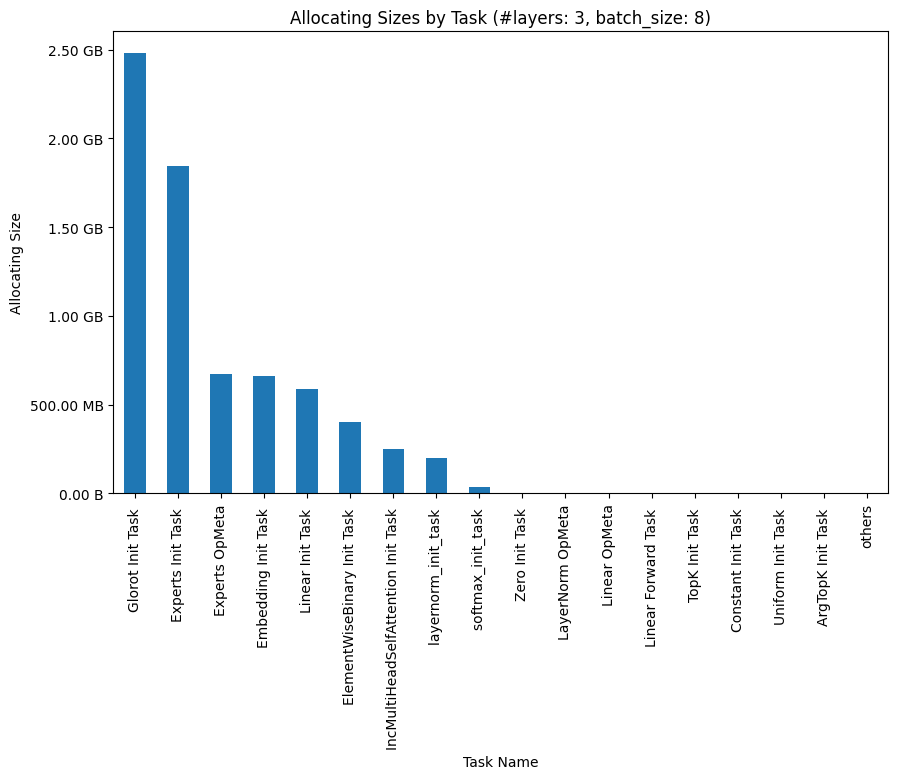


################# Mem Allocations Info (#layers: 2, batch_size: 8) #################
Total allocating size: 6639735872
Total allocating size (formatted): 6.64 GB
Number of unique values in 'kind' column: 2
List of unique values in 'kind' column: [6 5]
Number of unique values in 'task_name' column: 19
List of unique values in 'task_name' column: ['Glorot Init Task ' 'Uniform Init Task ' 'Zero Init Task '
 'Constant Init Task ' 'Embedding Init Task '
 'IncMultiHeadSelfAttention Init Task ' 'ElementWiseBinary Init Task '
 'layernorm_init_task ' 'Linear Init Task ' 'TopK Init Task '
 'Experts Init Task ' 'softmax_init_task ' 'ArgTopK Init Task '
 'Load Entire Dataset Task ' 'Embedding Forward Task '
 'Linear Forward Task ' 'Linear OpMeta' 'LayerNorm OpMeta'
 'Experts OpMeta']
#####################################################################################

                               task_name  kind allocating_size
7                      Glorot Init Task      6         2.43 GB
5  

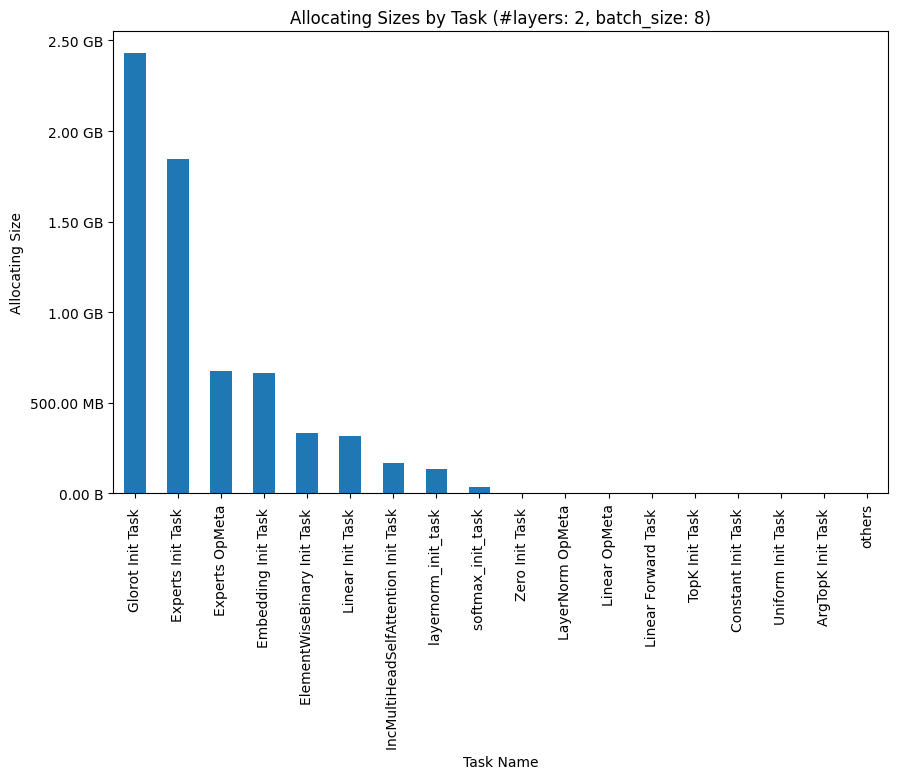


################# Mem Allocations Info (#layers: 1, batch_size: 8) #################
Total allocating size: 1530118144
Total allocating size (formatted): 1.53 GB
Number of unique values in 'kind' column: 2
List of unique values in 'kind' column: [6 5]
Number of unique values in 'task_name' column: 16
List of unique values in 'task_name' column: ['Glorot Init Task ' 'Uniform Init Task ' 'Zero Init Task '
 'Constant Init Task ' 'Embedding Init Task '
 'IncMultiHeadSelfAttention Init Task ' 'ElementWiseBinary Init Task '
 'layernorm_init_task ' 'Linear Init Task ' 'softmax_init_task '
 'ArgTopK Init Task ' 'Load Entire Dataset Task '
 'Embedding Forward Task ' 'Linear Forward Task ' 'Linear OpMeta'
 'LayerNorm OpMeta']
#####################################################################################

                               task_name  kind allocating_size
4                   Embedding Init Task      6       662.70 MB
9                      Linear Init Task      6       314.57 

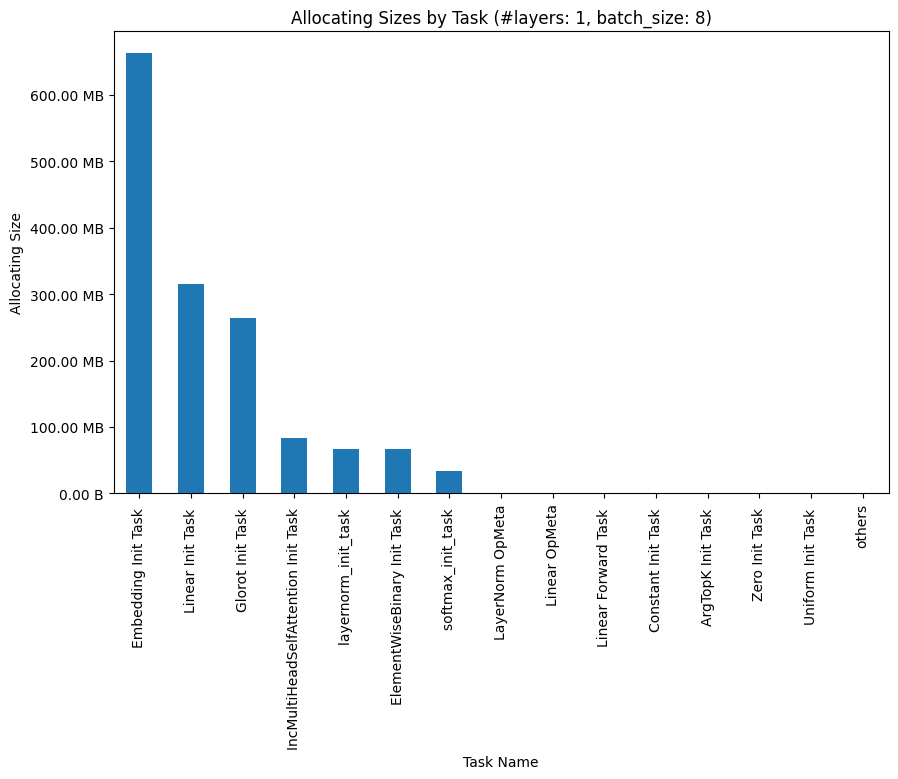

In [67]:
batch8_3layer_table = create_table("/Users/goliaro/Downloads/3layers_8batch.log")
print_table_info(batch8_3layer_table, 3, 8)
batch8_3layer_table = aggregate_sort_entries(batch8_3layer_table)
#batch8_3layer_table = format_byte_sizes(batch8_3layer_table)
gpu_table, cpu_table = get_cpu_gpu_tables(batch8_3layer_table)
print(format_byte_sizes(gpu_table))
plot_table(gpu_table, 3, 8)

print()

batch8_2layer_table = create_table("/Users/goliaro/Downloads/2layers_8batch.log")
print_table_info(batch8_2layer_table, 2, 8)
batch8_2layer_table = aggregate_sort_entries(batch8_2layer_table)
gpu_table, cpu_table = get_cpu_gpu_tables(batch8_2layer_table)
print(format_byte_sizes(gpu_table))
plot_table(gpu_table, 2, 8)

print()

batch8_1layer_table = create_table("/Users/goliaro/Downloads/1layers_8batch.log")
print_table_info(batch8_1layer_table, 1, 8)
batch8_1layer_table = aggregate_sort_entries(batch8_1layer_table)
gpu_table, cpu_table = get_cpu_gpu_tables(batch8_1layer_table)
print(format_byte_sizes(gpu_table))
plot_table(gpu_table, 1, 8)


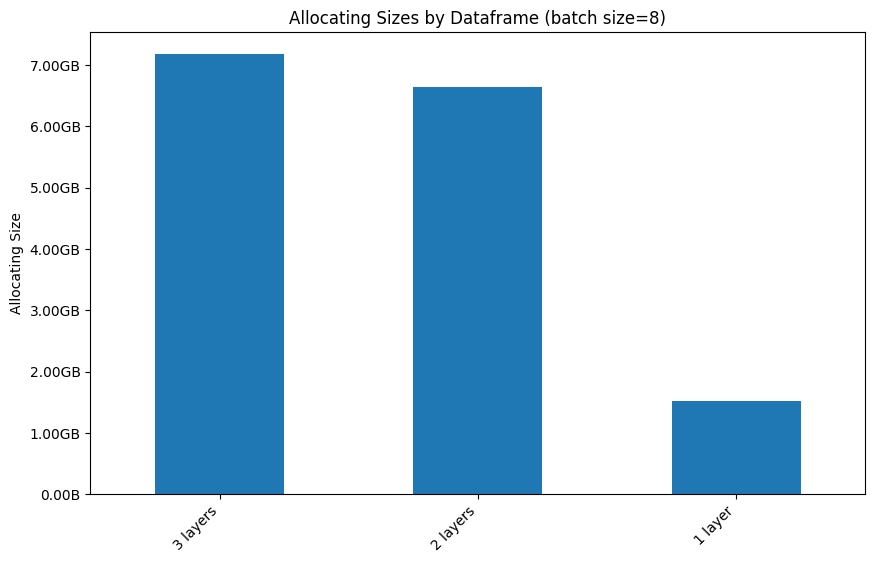

In [68]:
# create a new dataframe to hold the sums of allocating_size for each dataframe
df_sums = pd.DataFrame({
    'dataframe': ['3 layers', '2 layers', '1 layer'],
    'sum_allocating_size': [batch8_3layer_table['allocating_size'].sum(), batch8_2layer_table['allocating_size'].sum(), batch8_1layer_table['allocating_size'].sum()]
})

# plot the sums dataframe with a vertical bar chart
ax = df_sums.plot.bar(x='dataframe', y='sum_allocating_size', legend=None, figsize=(10, 6))

# format the y axis
def format_size2(value, tick_number):
    units = ['B', 'KB', 'MB', 'GB', 'TB', 'PB', 'EB', 'ZB', 'YB']
    size = value
    for unit in units:
        if size < 1000:
            return f"{size:.2f}{unit}"
        size /= 1000
    return f"{value:.2f}YB"

formatter = plt.FuncFormatter(format_size2)
ax.yaxis.set_major_formatter(formatter)

# set the title and axis labels
plt.title('Allocating Sizes by Dataframe (batch size=8)')
plt.ylabel('Allocating Size')
plt.xlabel(None)

# rotate the xtick labels diagonally for easier reading
plt.xticks(rotation=45, ha='right')

# save the plot to file
plt.savefig('total_allocating_sizes.png', bbox_inches='tight')

# show the plot
plt.show()

################# Mem Allocations Info (#layers: 2, batch_size: 4) #################
Total allocating size: 5764060224
Total allocating size (formatted): 5.76 GB
Number of unique values in 'kind' column: 2
List of unique values in 'kind' column: [6 5]
Number of unique values in 'task_name' column: 19
List of unique values in 'task_name' column: ['Glorot Init Task ' 'Uniform Init Task ' 'Zero Init Task '
 'Constant Init Task ' 'Embedding Init Task '
 'IncMultiHeadSelfAttention Init Task ' 'ElementWiseBinary Init Task '
 'layernorm_init_task ' 'Linear Init Task ' 'TopK Init Task '
 'Experts Init Task ' 'softmax_init_task ' 'ArgTopK Init Task '
 'Load Entire Dataset Task ' 'Embedding Forward Task '
 'Linear Forward Task ' 'Linear OpMeta' 'LayerNorm OpMeta'
 'Experts OpMeta']
#####################################################################################



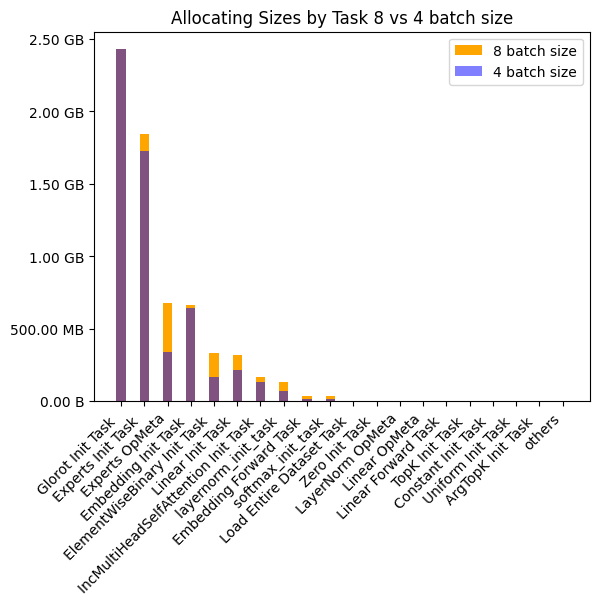


################# Mem Allocations Info (#layers: 1, batch_size: 4) #################
Total allocating size: 1294942208
Total allocating size (formatted): 1.29 GB
Number of unique values in 'kind' column: 2
List of unique values in 'kind' column: [6 5]
Number of unique values in 'task_name' column: 16
List of unique values in 'task_name' column: ['Uniform Init Task ' 'Glorot Init Task ' 'Zero Init Task '
 'Constant Init Task ' 'Embedding Init Task '
 'IncMultiHeadSelfAttention Init Task ' 'ElementWiseBinary Init Task '
 'layernorm_init_task ' 'Linear Init Task ' 'softmax_init_task '
 'ArgTopK Init Task ' 'Load Entire Dataset Task '
 'Embedding Forward Task ' 'Linear Forward Task ' 'Linear OpMeta'
 'LayerNorm OpMeta']
#####################################################################################



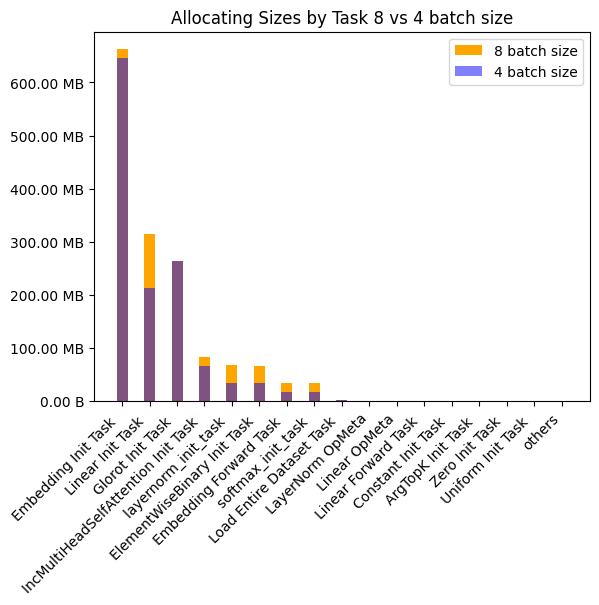

In [69]:
batch4_2layer_table = create_table("/Users/goliaro/Downloads/2layers_4batch.log")
print_table_info(batch4_2layer_table, 2, 4)
batch4_2layer_table = aggregate_sort_entries(batch4_2layer_table)
gpu_table, cpu_table = get_cpu_gpu_tables(batch4_2layer_table)
#print(format_byte_sizes(gpu_table))
#plot_table(gpu_table, 2, 4)
plot_tables_two_batch_sizes(batch8_2layer_table, batch4_2layer_table, 2, 8, 4)

print()

batch4_1layer_table = create_table("/Users/goliaro/Downloads/1layers_4batch.log")
print_table_info(batch4_1layer_table, 1, 4)
batch4_1layer_table = aggregate_sort_entries(batch4_1layer_table)
gpu_table, cpu_table = get_cpu_gpu_tables(batch4_1layer_table)
#print(format_byte_sizes(gpu_table))
#plot_table(gpu_table, 1, 4)
plot_tables_two_batch_sizes(batch8_1layer_table, batch4_1layer_table, 1, 8, 4)